In [2]:
import torch
import torch.nn as nn
import torch.utils as utils
import torch.nn.init as init
import torch.utils.data as data
import torchvision
import torchvision.transforms as transforms
from torch.autograd import Variable
from torch.utils.data import Dataset
import torch.nn.functional as F
import torchvision.models as models

import os
import numpy as np
import matplotlib.pyplot as plt
% matplotlib inline

import slack_notification as sn

In [4]:
class SketchModel(nn.Module):
    """
    https://github.com/HPrinz/sketch-recognition
    input size: (225. 225)
    """
    def __init__(self):
        super(SketchModel, self).__init__()
        self.output_num = 10
        self.filer_num = 64
        self.act = nn.LeakyReLU(0.2)
        self.conv1 = self.conv_block(1, self.filer_num*1, kernel_size=15, stride=3, padding=0, act_fn=self.act)
        self.conv2 = self.conv_block(self.filer_num*1, self.filer_num*2, kernel_size=3, stride=1, padding=0, act_fn=self.act)
        self.conv3 = self.conv_block(self.filer_num*2, self.filer_num*4, kernel_size=3, stride=1, padding=1, act_fn=self.act)
        self.conv4 = self.conv_block(self.filer_num*4, self.filer_num*4, kernel_size=3, stride=1, padding=1, act_fn=self.act)
        self.conv5 = self.conv_block(self.filer_num*4, self.filer_num*4, kernel_size=3, stride=1, padding=1, act_fn=self.act)
        self.conv6 = self.conv_block(self.filer_num*4, self.filer_num*8, kernel_size=7, stride=1, padding=0, act_fn=self.act)
        self.conv7 = self.conv_block(self.filer_num*8, self.filer_num*8, kernel_size=1, stride=1, padding=0, act_fn=self.act)
        
        self.conv8 = self.conv_block(self.filer_num*8, 50, kernel_size=1, stride=1, padding=0, act_fn=self.act)
        self.out = nn.Sequential(
            nn.Linear(50, self.output_num),
            nn.Sigmoid(),
        )
        self.pool = nn.MaxPool2d(kernel_size=3, stride=2, padding=0)
        self.drop = nn.Dropout2d(p=0.25)
        
    def forward(self, input):
        h = self.pool(self.conv1(input))
        h = self.pool(self.conv2(h))
        h = self.pool(self.conv5(self.conv4(self.conv3(h))))
        h = self.drop(self.conv6(h))
        h = self.conv8(self.drop(self.conv7(h)))
        h = self.out(self.flatten(h))
        return h
    
    def conv_block(self, in_dim, out_dim, kernel_size, stride, padding, act_fn):
        return nn.Sequential(
            nn.Conv2d(in_dim, out_dim, kernel_size, stride, padding),
            #insert batch norm
            nn.BatchNorm2d(out_dim),
            act_fn,
        )
    
    def flatten(self, x):
        bs = x.size()[0]
        return x.view(bs, -1)

In [5]:
data_transform = transforms.Compose([
    transforms.Grayscale(),
    transforms.Resize(225),
    transforms.ToTensor(),
])

data_transform_2 = transforms.Compose([
    transforms.Grayscale(),
    transforms.Resize(250),
    transforms.RandomCrop(225),
    transforms.ToTensor(),
])

data_transform_3 = transforms.Compose([
    transforms.Grayscale(),
    transforms.Resize(225),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
])

train_data = torchvision.datasets.ImageFolder(root='./train', transform=data_transform_3)
train_data_loader = torch.utils.data.DataLoader(train_data,
                                          batch_size=4,
                                          shuffle=True,
                                          num_workers=4)    
test_data = torchvision.datasets.ImageFolder(root='./test', transform=data_transform_3)
test_data_loader = torch.utils.data.DataLoader(test_data,
                                          batch_size=4,
                                          shuffle=True,
                                          num_workers=4)    

In [8]:
model = SketchModel().cuda()
lr = 1e-4
optim = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss().cuda()

In [9]:
def loss_plot(train_loss, test_loss, name):
    epoch = np.arange(len(train_loss))
    plt.clf()
    plt.plot(epoch, train_loss, label='train')
    plt.plot(epoch, test_loss, label='test')
    plt.legend()
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.savefig('./models/{}/loss.png'.format(name))
    sn.upload_image('./models/{}/loss.png'.format(name))
        
def train(epoch, name, send=True, init_epoch=0):
    
    if not os.path.exists('models/' + name):
        os.mkdir('models/'+name)
    train_loss = np.array([])
    test_loss = np.array([])
    for i in range(epoch):
        
        loss_per_epoch = 0
        acc = 0
        for batch_idx, (imgs, labels) in enumerate(train_data_loader):
            model.train()
            optim.zero_grad()
            imgs = imgs.cuda().float()
            labels = labels.cuda().long()
            estimated = model.forward(imgs)
            loss = criterion(estimated, labels)
            loss.backward()
            optim.step()
            loss_per_epoch += loss.data
            acc += torch.sum(labels == torch.argmax(estimated, dim=1)).cpu().numpy()
            
        train_loss = np.append(train_loss, loss_per_epoch)
        print("epoch: {}, train_loss: {}".format(i, train_loss[-1]))
        print("train_acc: {}".format(acc/len(train_data)))
        if send:
            sn.send_notification("epoch: {}, train_loss: {}".format(i, train_loss[-1]))
            sn.send_notification("train_acc: {}".format(acc/len(train_data)))
    
        loss_per_epoch = 0
        acc = 0
        for batch_idx, (imgs, labels) in enumerate(test_data_loader):
            model.eval()
            imgs = imgs.cuda().float()
            labels = labels.cuda().long()
            estimated = model.forward(imgs)
            loss = criterion(estimated, labels)
            loss_per_epoch += loss.data*len(train_data)/len(test_data)
            acc += torch.sum(labels == torch.argmax(estimated, dim=1)).cpu().numpy()
            
        test_loss = np.append(test_loss, loss_per_epoch)
        print("epoch: {}, test_loss: {}".format(i, test_loss[-1]))
        print("test_acc: {}".format(acc/len(test_data)))
        if send:
            sn.send_notification("epoch: {}, test_loss: {}".format(i, test_loss[-1]))
            sn.send_notification("test_acc: {}".format(acc/len(test_data)))
        loss_plot(train_loss, test_loss, name)
        
        torch.save(model.state_dict(), './models/{}/epoch_{}.pth'.format(name, i+init_epoch))

epoch: 0, train_loss: 394.0355529785156
train_acc: 0.28714285714285714
epoch: 0, test_loss: 387.1131286621094
test_acc: 0.48
epoch: 1, train_loss: 387.2898254394531
train_acc: 0.38571428571428573
epoch: 1, test_loss: 380.90228271484375
test_acc: 0.53
epoch: 2, train_loss: 382.88714599609375
train_acc: 0.4442857142857143
epoch: 2, test_loss: 379.9628601074219
test_acc: 0.58
epoch: 3, train_loss: 379.7556457519531
train_acc: 0.46714285714285714
epoch: 3, test_loss: 374.04278564453125
test_acc: 0.58
epoch: 4, train_loss: 375.786376953125
train_acc: 0.5085714285714286
epoch: 4, test_loss: 369.2697448730469
test_acc: 0.67
epoch: 5, train_loss: 372.2107849121094
train_acc: 0.5157142857142857
epoch: 5, test_loss: 366.82257080078125
test_acc: 0.67
epoch: 6, train_loss: 368.6688232421875
train_acc: 0.5642857142857143
epoch: 6, test_loss: 364.117431640625
test_acc: 0.63
epoch: 7, train_loss: 364.5845947265625
train_acc: 0.6157142857142858
epoch: 7, test_loss: 360.4264831542969
test_acc: 0.76
epo

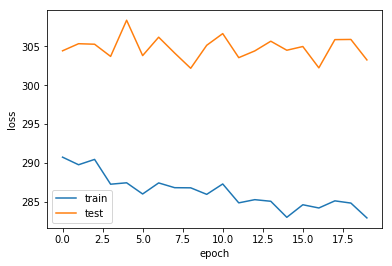

In [10]:
train(40, '1203_4', send=True)
lr = 1e-5
optim = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)
train(20, '1203_4', send=True, init_epoch=40)